In [3]:
pip install yfinance

/tmp/ipython-input-4-4206307110.py:11: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Columns after flattening: Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')
Historical Stock Data:
                 Close
Date                  
2023-01-03  123.470604
2023-01-04  124.744118
2023-01-05  123.421265
2023-01-06  127.962410
2023-01-09  128.485626
...                ...
2024-03-08  169.705078
2024-03-11  171.712952
2024-03-12  172.190079
2024-03-13  170.102692
2024-03-14  171.961441

[301 rows x 1 columns]


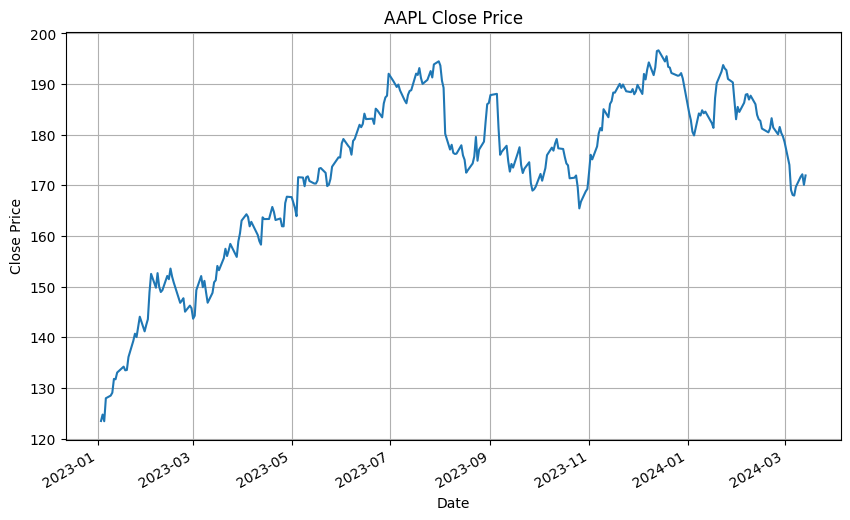

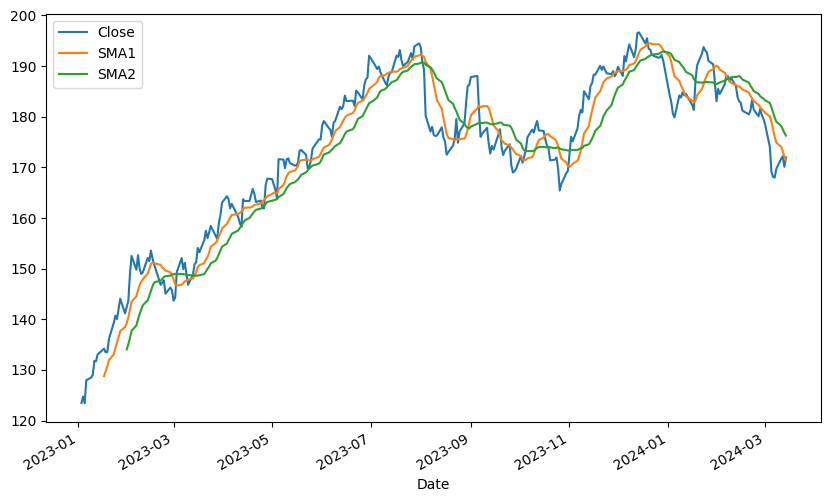

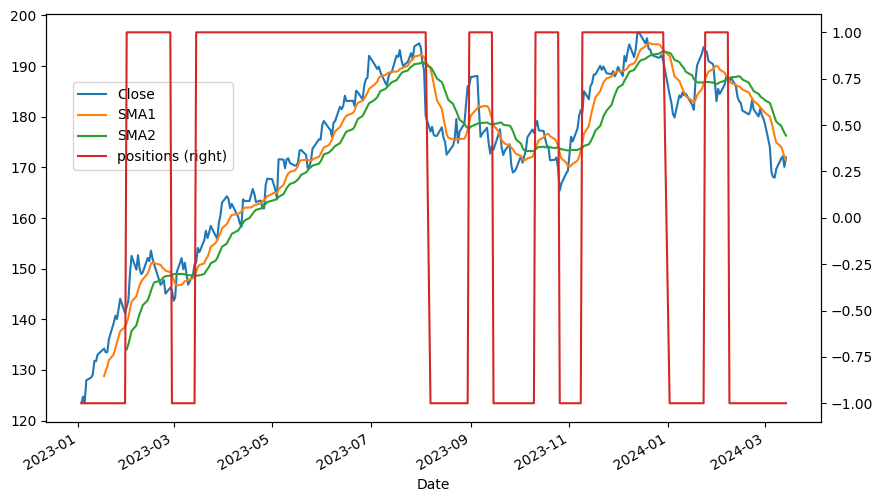

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline as plyo

def get_historical_data(ticker, start_date, end_date):
    try:
        # Fetch historical data from Yahoo Finance
        data = yf.download(ticker, start=start_date, end=end_date)
        # Flatten the multi-level column index
        data.columns = ['_'.join(col).strip() for col in data.columns.values]
        print("Columns after flattening:", data.columns)  # Print columns for inspection
        # Select the 'Close' column
        data = data[['Close_AAPL']].copy()
        # Rename the column back to 'Close' for consistency with the rest of the code
        data.columns = ['Close']
        return data
    except Exception as e:
        print("Error fetching data:", e)
        return None

if __name__ == "__main__":
    # Set the stock ticker symbol and date range
    ticker_symbol = "AAPL"  # Replace with your desired ticker symbol
    start_date = "2023-01-01"
    end_date = "2024-03-15"

    # Get historical data
    historical_data = get_historical_data(ticker_symbol, start_date, end_date)

    if historical_data is not None:
        print("Historical Stock Data:")
        print(historical_data)

        # Plot the data using matplotlib as a temporary fix
        historical_data['Close'].plot(figsize=(10,6))
        plt.title(f"{ticker_symbol} Close Price")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.grid(True)
        plt.show()

        # Calculate rolling statistics
        window = 20
        sym = "Close"  # Use "Close" column for calculating the statistics
        historical_data['min'] = historical_data[sym].rolling(window=window).min()
        historical_data['mean'] = historical_data[sym].rolling(window=window).mean()
        historical_data['std'] = historical_data[sym].rolling(window=window).std()
        historical_data['median'] = historical_data[sym].rolling(window=window).median()
        historical_data['max'] = historical_data[sym].rolling(window=window).max()
        historical_data['ewma'] = historical_data[sym].ewm(halflife=0.5, min_periods=window).mean()

        # Plot the stock data with moving averages
        historical_data['SMA1'] = historical_data[sym].rolling(window=10).mean()
        historical_data['SMA2'] = historical_data[sym].rolling(window=20).mean()
        historical_data[[sym, 'SMA1', 'SMA2']].tail()
        historical_data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6))

        # Determine positions based on moving averages crossover
        historical_data['positions'] = np.where(historical_data['SMA1'] > historical_data['SMA2'], 1, -1)

        # Plot the stock data with moving averages and positions
        ax = historical_data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(10, 6), secondary_y='positions')
        ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
        plt.show()

    else:
        print("Data retrieval failed.")

In [5]:
#Predicting Monthly Returns
import yfinance as yf
import pandas as pd

# Define the list of ticker symbols
ticker_symbols = ['AAPL','MSFT','GOOGL']

# Define the time interval
start_date = '2018-01-01'
end_date = '2023-07-31'

# Create an empty list to store DataFrames
dataframes = []

# Loop through each ticker symbol
for ticker_symbol in ticker_symbols:
    # Retrieve financial data using yfinance
    data = yf.Ticker(ticker_symbol)

    # Extract relevant financial metrics
    yearly_data = data.history(start=start_date, end=end_date, interval='1mo')

    # Extract specific attributes from data.info dictionary
    info = data.info
    market_cap = info.get('marketCap', None)
    eps = info.get('trailingEps', None)
    pe_ratio = info.get('trailingPE', None)
    pb_ratio = info.get('priceToBook', None)  # Add PB ratio
    dividend_yield = info.get('trailingAnnualDividendYield', None)
    dividend_pay_date = info.get('exDividendDate', None)
    dividend_per_share = info.get('trailingAnnualDividendRate', None)
    book_value = info.get('bookValue', None)
    ebitda = info.get('ebitda', None)
    high_52_week = info.get('fiftyTwoWeekHigh', None)
    low_52_week = info.get('fiftyTwoWeekLow', None)
    currency = info.get('currency', None)
    exchange = info.get('exchange', None)

    # Create a DataFrame for the current stock
    stock_data = yearly_data.copy()
    stock_data['Ticker'] = ticker_symbol
    stock_data['MarketCap'] = market_cap
    stock_data['EPS'] = eps
    stock_data['PE'] = pe_ratio
    stock_data['PB'] = pb_ratio  # Add PB ratio
    stock_data['DividendYield'] = dividend_yield
    stock_data['DividendPayDate'] = dividend_pay_date
    stock_data['DividendPerShare'] = dividend_per_share
    stock_data['BookValue'] = book_value
    stock_data['EBITDA'] = ebitda
    stock_data['High52Week'] = high_52_week
    stock_data['Low52Week'] = low_52_week
    stock_data['Currency'] = currency
    stock_data['Exchange'] = exchange

# Append the DataFrame to the list
dataframes.append(stock_data)

# Concatenate all DataFrames into a single DataFrame
financial_data = pd.concat(dataframes, ignore_index=True)

# Calculate monthly returns
financial_data['MonthlyReturns'] = financial_data.groupby('Ticker')['Close'].pct_change()

# Save the DataFrame to a CSV file
financial_data.to_csv('financial_data.csv', index=False)


In [6]:
import pandas as pd

# Read the CSV file into a DataFrame
financial_data = pd.read_csv('financial_data.csv')

# Display the DataFrame
print(financial_data)



          Open        High         Low       Close      Volume  Dividends  \
0    52.337115   59.542900   52.337115   58.758602   657748000        0.0   
1    58.448965   59.018551   49.552817   54.866947  1026814000        0.0   
2    55.146269   58.556815   48.906690   51.547848  1042336000        0.0   
3    51.074690   54.548357   49.416138   50.625385   984928000        0.0   
4    50.512059   55.574203   50.094068   54.672112   740734000        0.0   
..         ...         ...         ...         ...         ...        ...   
62   89.443582  105.954553   88.886915  103.111610   859933900        0.0   
63  101.779594  108.519173  101.322337  106.700081   604106300        0.0   
64  106.203062  125.676279  103.091725  122.137505   820545400        0.0   
65  122.087792  128.270704  115.407853  118.986389   656756700        0.0   
66  118.529145  132.942711  114.662336  131.928787   708341500        0.0   

    Stock Splits Ticker      MarketCap   EPS  ...  DividendYield  \
0      

In [7]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
import numpy as np

# Define the list of ticker symbols
ticker_symbols = ['AAPL','GOOGL','MSFT']

# Define the time intervals
Data_start_date = '2018-01-01'
Data_end_date = '2023-10-01'
test_start_date = '2022-03-01'  # 20% for test
test_end_date = '2023-10-01'  # 20% for test

# Create an empty dictionary to store results for each stock
results = {}

# Define a dictionary to store actual and predicted values for each stock
actual_predicted_values = {}

# Loop through each ticker symbol as the "current" stock
for current_stock_symbol in ticker_symbols:
    # Create an empty list to store DataFrames
    dataframes = []

    # Loop through each ticker symbol
    for ticker_symbol in ticker_symbols:
        # Retrieve financial data using yfinance
        data = yf.Ticker(ticker_symbol)

        # Extract relevant financial metrics
        info = data.info
        market_cap = info.get('marketCap', None)
        volume = info.get('averageVolume', None)
        pe_ratio = info.get('trailingPE', None)
        operating_cf = info.get('operatingCashflow', None)
        dividend_yield = info.get('trailingAnnualDividendYield', None)
        eps = info.get('trailingEps', None)
        pb_ratio = info.get('priceToBook', None)
        high_52_week = info.get('fiftyTwoWeekHigh', None)
        low_52_week = info.get('fiftyTwoWeekLow', None)
        book_value = info.get('bookValue', None)
        ebitda = info.get('ebitda', None)


        # Extract historical data
        Data_set = data.history(start=Data_start_date, end=Data_end_date, interval='1mo')
        test_data = data.history(start=test_start_date, end=test_end_date, interval='1mo')

        # Check if the train_data contains enough data points
        if len(Data_set) < 2:
            print(f"Insufficient data for {ticker_symbol}, skipping...")
            continue  # Skip this stock if not enough data

        print(f"Processing data for {ticker_symbol}...")

        # Create a DataFrame for the current stock
        stock_data = pd.DataFrame({
            'MarketCap': market_cap,
            'Volume': volume,
            'PERatio': pe_ratio,
            'OperatingCF': operating_cf,
            'DividendYield': dividend_yield,
            'EPS': eps,
            'PBRatio': pb_ratio,
            'High52Week': high_52_week,
            'Low52Week': low_52_week,
            'BookValue': book_value,
            'EBITDA': ebitda,
            'Close': Data_set['Close'],  # Include Close prices
        }, index=Data_set.index)

        # Append the DataFrame to the list
        dataframes.append(stock_data)

    # Concatenate all DataFrames into a single DataFrame
    if dataframes:
        financial_data = pd.concat(dataframes)

        # Calculate monthly returns for each stock
        financial_data['MonthlyReturns'] = financial_data.groupby(level=0)['Close'].pct_change()

        # Drop rows with missing values
        financial_data.dropna(inplace=True)

        # Prepare features and target
        X = financial_data.drop(columns=['MonthlyReturns'])
        y = financial_data['MonthlyReturns']

        print("Shape of X before imputation:", X.shape)

        # Handle missing values in X
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)

        # Convert the imputed numpy array back to a pandas DataFrame with original column names
        X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)


        print("Shape of X after imputation:", X_imputed_df.shape)

        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

        print("Shape of X_train:", X_train.shape)
        print("Shape of X_test:", X_test.shape)
        print("Shape of y_train:", y_train.shape)
        print("Shape of y_test:", y_test.shape)

        # Define parameter grid for hyperparameter tuning
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        # Initialize the Random Forest regressor
        rf_regressor = RandomForestRegressor(random_state=42)

        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid, n_iter=10, cv=3,
                                           n_jobs=-1)
        random_search.fit(X_train, y_train)

        # Get the best model from the random search
        best_rf_model = random_search.best_estimator_

        # Predict on the test set
        y_pred = best_rf_model.predict(X_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print("Best Model for", current_stock_symbol, ":", best_rf_model)
        print("Root Mean Squared Error for", current_stock_symbol, ":", rmse)

        # Store results for this stock in the dictionary
        results[current_stock_symbol] = {
            'Model': best_rf_model,
            'RMSE': rmse
        }

        # Get the data for this stock (for prediction)
        data = yf.Ticker(current_stock_symbol)
        Data_set = data.history(start=Data_start_date, end=Data_end_date, interval='1mo')
        test_data = data.history(start=test_start_date, end=test_end_date, interval='1mo')

        # Create a DataFrame for the current stock
        stock_data = pd.DataFrame({
            'Close': Data_set['Close'],  # Include Close prices
        }, index=Data_set.index)

        # Prepare features for prediction - Ensure consistent column names
        features_for_prediction = pd.DataFrame({
            'MarketCap': [info.get('marketCap', None)],
            'Volume': [info.get('averageVolume', None)],
            'PERatio': [info.get('trailingPE', None)],
            'OperatingCF': [info.get('operatingCashflow', None)],
            'DividendYield': [info.get('trailingAnnualDividendYield', None)],
            'EPS': [info.get('trailingEps', None)],
            'PBRatio': [info.get('priceToBook', None)],
            'High52Week': [info.get('fiftyTwoWeekHigh', None)],
            'Low52Week': [info.get('fiftyTwoWeekLow', None)],
            'BookValue': [info.get('bookValue', None)],
            'EBITDA': [info.get('ebitda', None)],
            'Close': [test_data['Close'].iloc[-1]],
        })

        # Ensure the order of columns in features_for_prediction matches X_train
        features_for_prediction = features_for_prediction[X_train.columns]


        # Predict on the features for prediction
        predicted_return = best_rf_model.predict(features_for_prediction)

        # Split the data into train and test sets for this stock
        X_train_stock, X_test_stock, y_train_stock, y_test_stock = train_test_split(X_imputed_df, y, test_size=0.2,
                                                                                    random_state=42)

        # Predict on the test set for this stock
        y_pred_stock = best_rf_model.predict(X_test_stock)

        # Calculate RMSE for this stock
        rmse_stock = np.sqrt(mean_squared_error(y_test_stock, y_pred_stock))


        # Store actual and predicted values for this stock
        actual_predicted_values[current_stock_symbol] = {
            'Actual': y_test_stock,
            'Predicted': y_pred_stock,
            'RMSE': rmse_stock,
            'Dates': test_data.index
        }

        # Print feature importances for this stock
        print(f"Feature Importances for {current_stock_symbol}:")
        feature_importances = best_rf_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        print(feature_importance_df)

        # Print the actual and predicted values for this stock
        print(f"Stock: {current_stock_symbol}")
        print("RMSE:", rmse_stock)

        actual_values = actual_predicted_values[current_stock_symbol]['Actual']
        predicted_values = actual_predicted_values[current_stock_symbol]['Predicted']
        dates = actual_predicted_values[current_stock_symbol]['Dates']

        # Ensure dates and values have the same length
        min_len = min(len(dates), len(actual_values), len(predicted_values))
        dates = dates[:min_len]
        actual_values = actual_values[:min_len]
        predicted_values = predicted_values[:min_len]


        for date, actual, predicted in zip(dates, actual_values, predicted_values):
            print(f"Date: {date}, Actual: {actual}, Predicted: {predicted}")

        print()

    else:
        print(f"No sufficient data for any stock after preprocessing for {current_stock_symbol}.")

# Print the results for all stocks
for ticker_symbol, result in results.items():
    print(f"Stock: {ticker_symbol}")
    print("Best Model:", result['Model'])
    print("RMSE:", result['RMSE'])

Processing data for AAPL...
Processing data for GOOGL...
Processing data for MSFT...
Shape of X before imputation: (138, 12)
Shape of X after imputation: (138, 12)
Shape of X_train: (110, 12)
Shape of X_test: (28, 12)
Shape of y_train: (110,)
Shape of y_test: (28,)
Best Model for AAPL : RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=150, random_state=42)
Root Mean Squared Error for AAPL : 0.17262553191596156
Feature Importances for AAPL:
          Feature  Importance
1          Volume    0.180732
3     OperatingCF    0.168640
11          Close    0.152634
5             EPS    0.091024
6         PBRatio    0.067548
0       MarketCap    0.057138
7      High52Week    0.056509
10         EBITDA    0.050686
9       BookValue    0.050539
4   DividendYield    0.045540
2         PERatio    0.044699
8       Low52Week    0.034313
Stock: AAPL
RMSE: 0.17262553191596156
Date: 2022-03-01 00:00:00-05:00, Actual: 1.1752363530908831, Pred

In [8]:
import yfinance as yf
import pandas as pd

# Define the stock symbol and date range
stock_symbol = "MSFT"
start_date = "2022-01-01"
end_date = "2023-09-01"

# Fetch daily historical data from Yahoo Finance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Flatten the multi-level column index and select the 'Close' column
data.columns = ['_'.join(col).strip() for col in data.columns.values]
print("Columns after flattening:", data.columns) # Added for inspection
data = data.rename(columns={'Close_MSFT': 'Close'})[['Close']]


# Resample the daily data to monthly frequency and select the first day of each month
monthly_data = data['Close'].resample('M').first()

# Calculate monthly returns
monthly_returns = monthly_data.pct_change().dropna()

# Print the monthly returns
print(monthly_returns)

/tmp/ipython-input-8-3522700065.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Columns after flattening: Index(['Close_MSFT', 'High_MSFT', 'Low_MSFT', 'Open_MSFT', 'Volume_MSFT'], dtype='object')
Date
2022-02-28   -0.077640
2022-03-31   -0.042752
2022-04-30    0.049059
2022-05-31   -0.080635
2022-06-30   -0.040129
2022-07-31   -0.047133
2022-08-31    0.070999
2022-09-30   -0.061355
2022-10-31   -0.075499
2022-11-30   -0.052214
2022-12-31    0.119375
2023-01-31   -0.059327
2023-02-28    0.054971
2023-03-31   -0.023197
2023-04-30    0.166321
2023-05-31    0.063817
2023-06-30    0.090807
2023-07-31    0.016267
2023-08-31   -0.004882
Freq: ME, Name: Close, dtype: float64



/tmp/ipython-input-8-3522700065.py:19: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [9]:
# Define the feature values for prediction
features_for_prediction = pd.DataFrame({
    'OperatingCF': [1190000000],
    'PBRatio': [40.14],
    'PERatio': [106.61],
    'Close': [457.78],
    'Volume': [25995744],
    'MarketCap': [1124580000000],
    'EPS': [4.14],
    'DividendYield': [ 0.0004],
    'High52Week': [480.0], # Added sample value
    'Low52Week': [120.0],  # Added sample value
    'BookValue': [30.0],   # Added sample value
    'EBITDA': [1300000000], # Added sample value
})

# Specify the stock symbol for which you want to make a prediction
stock_symbol = 'AAPL'  # Replace with the desired stock symbol

# Retrieve the trained model for the specified stock symbol from the 'results' dictionary
best_rf_model = results[stock_symbol]['Model']

# Ensure the order of columns in features_for_prediction matches X_train from the previous cell
features_for_prediction = features_for_prediction[X_train.columns]

# Use the trained model to predict the next month's returns
predicted_return = best_rf_model.predict(features_for_prediction)

print(f"Predicted Monthly Return for {stock_symbol}: {predicted_return[0]:.4f}")

Predicted Monthly Return for AAPL: 0.8534
